In [4]:
import fenics as f
import matplotlib.pyplot as plt
from models import velocity_field, t_transport_sim, mesh_2d
import h_transport_materials as htm

----------  Running for dT=0 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


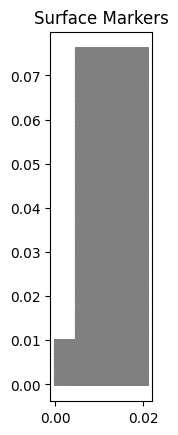

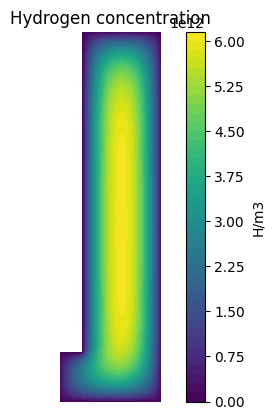

Total surface: 1.48e-02 m2
Total flux: 1.77e+05 H/s/m
Average concentration: 3.56e+12 H/m3
k: 3.37e-06 m/s
(3.370949415496478e-06, array(3.56489928e+12), 177363.76496870597)
----------  Running for dT=0.1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=1.0e+00


KeyboardInterrupt: 

In [5]:
if __name__ == "__main__":
    # Generating mesh
    # x1 = 0.00476
    # x2 = 0.0162
    # y1 = 0.01
    # y2 = 0.0761
    # resolution = 30
    # mesh_fenics, surface_markers, left_id, top_id, right_id, bottom_id, upper_left_id, left_top_id = LMeshmshr(x1, x2, y1, y2, resolution)

    mesh_fenics, volume_markers, surface_markers, correspondance_dict = mesh_2d()

    T_hot = 700 + 273.15
    dt_array = [0, 0.1, 0.2, 0.4, 0.8, 2, 3.5, 10]

    diffusivities = htm.diffusivities.filter(material="flibe").filter(author=["nakamura", "anderl"])

    k_array_array = []
    for diffusivity in diffusivities:
        k_array = []
        c_array = []
        f_array = []
        for dT in dt_array:
            print(f"----------  Running for dT={dT} K  ----------")
            foldername = f"Results/dt={dT}/"
            T_cold = T_hot - dT
            u, p, T = velocity_field(
                T_cold=T_cold,
                T_hot=T_hot,
                my_mesh=mesh_fenics,
                surface_markers=surface_markers,
                correspondance_dict=correspondance_dict,
            )

            f.XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(
                T, "temperature", 1, f.XDMFFile.Encoding.HDF5
            )
            f.XDMFFile(foldername + "velocity_field.xdmf").write(u)

            # plt.figure()
            # plt.title("Velocity field")
            # CS = f.plot(u, scale=1e-3)
            # plt.colorbar(CS, label="m/s")
            # plt.axis("off")
            # plt.show()

            # plt.figure()
            # TS = f.plot(T, cmap="inferno")
            # plt.colorbar(TS, label="K")
            # plt.show()

            k = t_transport_sim(
                T,
                mesh_fenics,
                u,
                volume_markers=volume_markers,
                surface_markers=surface_markers,
                correspondance_dict=correspondance_dict,
                D_0 = diffusivity.pre_exp.magnitude, 
                E_D = diffusivity.act_energy.magnitude
            )
            print(k)
            k_array.append(k[0])
            c_array.append(k[1])
            f_array.append(k[2])

        k_array_array.append(k_array)

    # plt.figure()
    # plt.plot(dt_array, k_array, "-x", linewidth=3)
    # plt.xlabel("Temperature difference [K]")
    # plt.ylabel("Transport Coefficient [m/s]")

    # plt.figure()
    # plt.plot(dt_array, c_array, "-x", linewidth=3)
    # plt.xlabel("Temperature difference [K]")
    # plt.ylabel("Average Concentration")

    # plt.figure()
    # plt.plot(dt_array, f_array, "-x", linewidth=3)
    # plt.xlabel("Temperature difference [K]")
    # plt.ylabel("Flux")

    # xdmf_file = XDMFFile("mesh_fencis.xdmf")
    # xdmf_file.write(mesh_fenics)
    # xdmf_file.close()

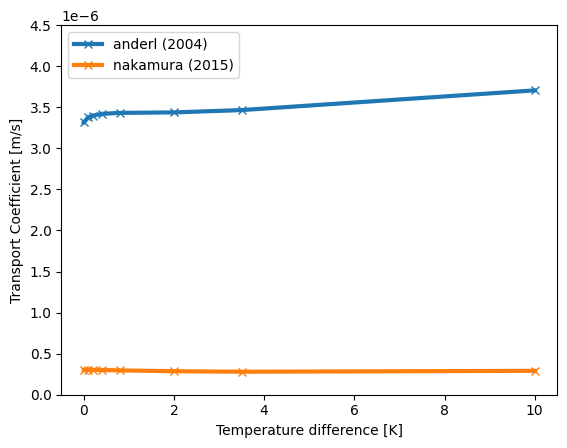

In [ ]:
plt.figure()
for i in range(len(k_array_array)):
    plt.plot(dt_array, k_array_array[i], '-x', label=str(diffusivities[i].author + " (" + str(diffusivities[i].year) + ")"), linewidth=3)
plt.xlabel("Temperature difference [K]")
plt.ylabel("Transport Coefficient [m/s]")
# plt.yscale('log')
plt.ylim([0, 4.5e-06])
plt.legend(loc = "upper left")
plt.show()